## Build a simple trading strategy 

In [40]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

### 1. Munging the stock data and add two columns - MA10 and MA50

In [2]:
#import FB's stock data, add two columns - MA10 and MA50
#use dropna to remove any "Not a Number" data
fb = pd.read_csv('facebook.csv')
fb['MA10'] = fb['Close'].rolling(10).mean()
fb['MA50'] = fb['Close'].rolling(50).mean()
fb = fb.dropna()
fb.head()

,Date,Open,High,Low,Close,Adj Close,Volume,MA10,MA50
49,2015-03-13,22.559999,22.760000,22.250000,22.700001,22.116024,8982200,22.648,21.0174
50,2015-03-16,22.879999,23.110001,22.730000,22.969999,22.379078,5923900,22.685,21.0758
51,2015-03-17,22.920000,23.260000,22.760000,23.250000,22.651876,7497500,22.792,21.1382
52,2015-03-18,23.250000,23.370001,22.660000,22.870001,22.281652,10337600,22.836,21.1998
53,2015-03-19,22.950001,23.299999,22.780001,23.219999,22.622650,7768900,22.872,21.2804


### 2. Add "Shares" column to make decisions base on the strategy 

In [3]:
#Add a new column "Shares", if MA10>MA50, denote as 1 (long one share of stock), otherwise, denote as 0 (do nothing)

fb['Shares'] = [1 if fb.loc[ei, 'MA10']>fb.loc[ei, 'MA50'] else 0 for ei in fb.index]

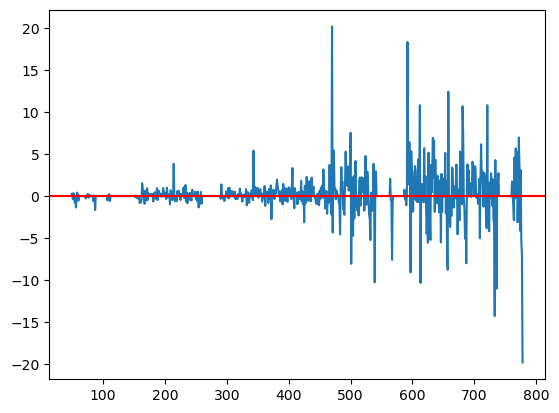

In [4]:
#Add a new column "Profit" using List Comprehension, for any rows in fb, if Shares=1, the profit is calculated as the close price of 
#tomorrow - the close price of today. Otherwise the profit is 0.

#Plot a graph to show the Profit/Loss

fb['Close1'] = fb['Close'].shift(-1)
fb['Profit'] = [fb.loc[ei, 'Close1'] - fb.loc[ei, 'Close'] if fb.loc[ei, 'Shares']==1 else 0 for ei in fb.index]
fb['Profit'].plot()
plt.axhline(y=0, color='red')

### 3. Use .cumsum() to display our model's performance if we follow the strategy 

In [5]:
#Use .cumsum() to calculate the accumulated wealth over the period

fb['wealth'] = fb['Profit'].cumsum()
fb.tail()

,Date,Open,High,Low,Close,Adj Close,Volume,MA10,MA50,Shares,Close1,Profit,wealth
775,2018-01-30,241.110001,246.419998,238.410004,242.720001,242.720001,14270800,235.692003,210.030001,1,245.800003,3.080002,177.820011
776,2018-01-31,245.770004,249.270004,244.449997,245.800003,245.800003,11964400,237.800003,210.713801,1,240.500000,-5.300003,172.520008
777,2018-02-01,238.520004,246.899994,238.059998,240.500000,240.500000,12980600,239.406003,211.296601,1,233.520004,-6.979996,165.540012
778,2018-02-02,237.000000,237.970001,231.169998,233.520004,233.520004,17961600,239.747003,211.685401,1,213.699997,-19.820007,145.720005
779,2018-02-05,227.000000,233.229996,205.000000,213.699997,213.699997,28869000,237.748003,211.638401,1,NaN,NaN,NaN


Text(0.5, 1.0, 'Total money you win is 145.72000500000001')

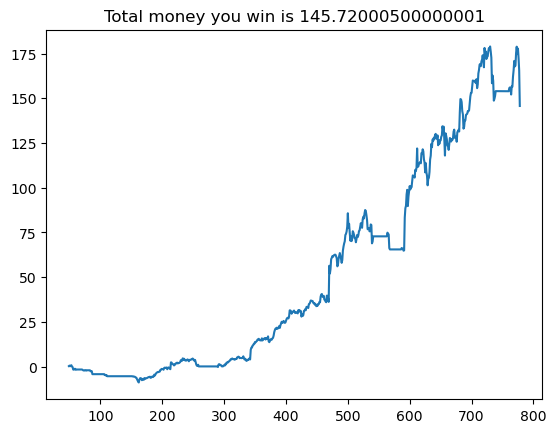

In [6]:
#plot the wealth to show the growth of profit over the period

fb['wealth'].plot()
plt.title('Total money you win is {}'.format(fb.loc[fb.index[-2], 'wealth']))

In [7]:
ms = pd.read_csv('microsoft.csv')
ms.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2014-12-31,46.730000,47.439999,46.450001,46.450001,42.848763,21552500
1,2015-01-02,46.660000,47.419998,46.540001,46.759998,43.134731,27913900
2,2015-01-05,46.369999,46.730000,46.250000,46.330002,42.738068,39673900
3,2015-01-06,46.380001,46.750000,45.540001,45.650002,42.110783,36447900
4,2015-01-07,45.980000,46.459999,45.490002,46.230000,42.645817,29114100


In [11]:
# let play around with ms data by calculating the log daily return
ms['LogReturn'] = np.log(ms['Close']).shift(-1) - np.log(ms['Close'])

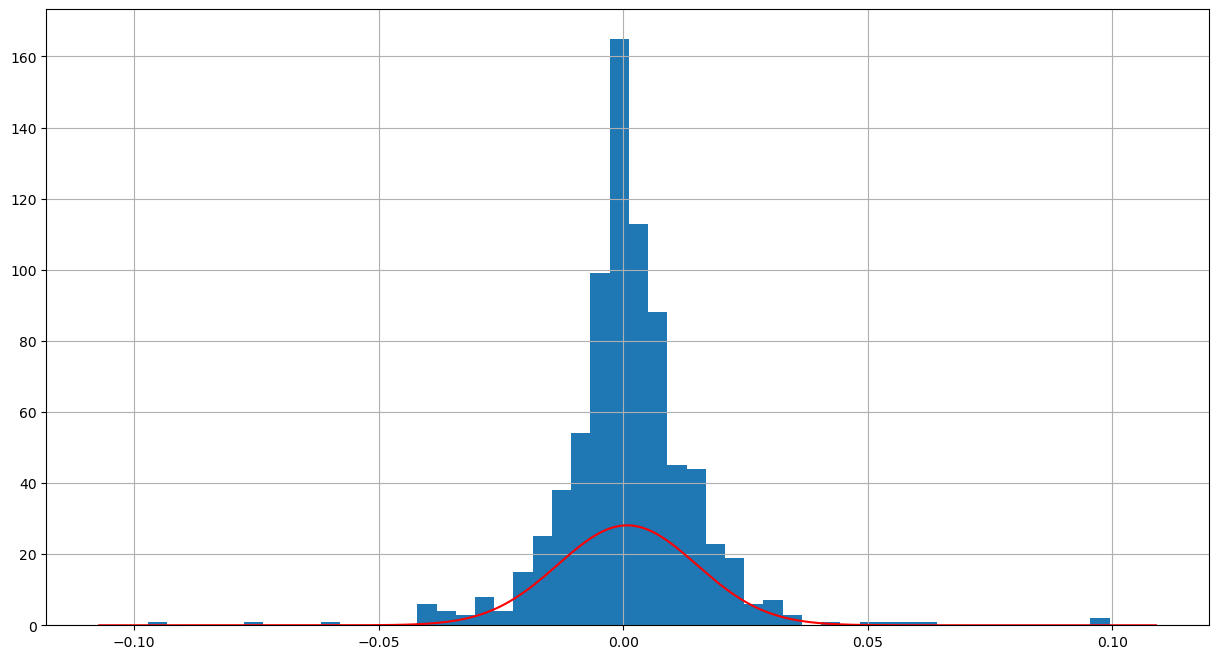

In [12]:
# Plot a histogram to show the distribution of log return of Microsoft's stock. 
# You can see it is very close to a normal distribution
from scipy.stats import norm
mu = ms['LogReturn'].mean()
sigma = ms['LogReturn'].std(ddof=1)

density = pd.DataFrame()
density['x'] = np.arange(ms['LogReturn'].min()-0.01, ms['LogReturn'].max()+0.01, 0.001)
density['pdf'] = norm.pdf(density['x'], mu, sigma)

ms['LogReturn'].hist(bins=50, figsize=(15, 8))
plt.plot(density['x'], density['pdf'], color='red')
plt.show()

## Calculate the probability of the stock price will drop over a certain percentage in a day

In [13]:
# probability that the stock price of microsoft will drop over 5% in a day
prob_return1 = norm.cdf(-0.05, mu, sigma)
print('The Probability is ', prob_return1)

The Probability is  0.00017118482608677817


## Calculate the probability of the stock price will drop over a certain percentage in a year

In [14]:
# drop over 40% in 220 days
mu220 = 220*mu
sigma220 = (220**0.5) * sigma
print('The probability of dropping over 40% in 220 days is ', norm.cdf(-0.4, mu220, sigma220))

The probability of dropping over 40% in 220 days is  0.002912363313330548


## Calculate Value at risk (VaR)

In [15]:
# Value at risk(VaR)
VaR = norm.ppf(0.05, mu, sigma)
print('Single day value at risk ', VaR)

Single day value at risk  -0.022523362407065


In [16]:
# Quatile 
# 5% quantile
print('5% quantile ', norm.ppf(0.05, mu, sigma))
# 95% quantile
print('95% quantile ', norm.ppf(0.95, mu, sigma))

5% quantile  -0.022523362407065
95% quantile  0.024163825379311034


In [17]:
# we will use log return for average stock return of Microsoft

ms['logReturn'] = np.log(ms['Close'].shift(-1)) - np.log(ms['Close'])

In [21]:
from scipy.stats import norm

# Lets build 90% confidence interval for log return
sample_size = ms['logReturn'].shape[0]
sample_mean = ms['logReturn'].mean()
sample_std = ms['logReturn'].std(ddof=1) / sample_size**0.5

# left and right quantile
z_left = norm.ppf(0.1)
z_right = norm.ppf(0.9)

# upper and lower bound
interval_left = sample_mean+z_left*(sample_std/np.sqrt(sample_size))
interval_right = sample_mean+z_right*(sample_std/np.sqrt(sample_size))

In [22]:
# 90% confidence interval tells you that there will be 90% chance that the average stock return lies between "interval_left"
# and "interval_right".

print('90% confidence interval is ', (interval_left, interval_right))

90% confidence interval is  (0.0007969139882812468, 0.0008435489839647978)


# Hypothesis testing

In [24]:
# import microsoft.csv, and add a new feature - logreturn
ms['logReturn'] = np.log(ms['Close'].shift(-1)) - np.log(ms['Close'])

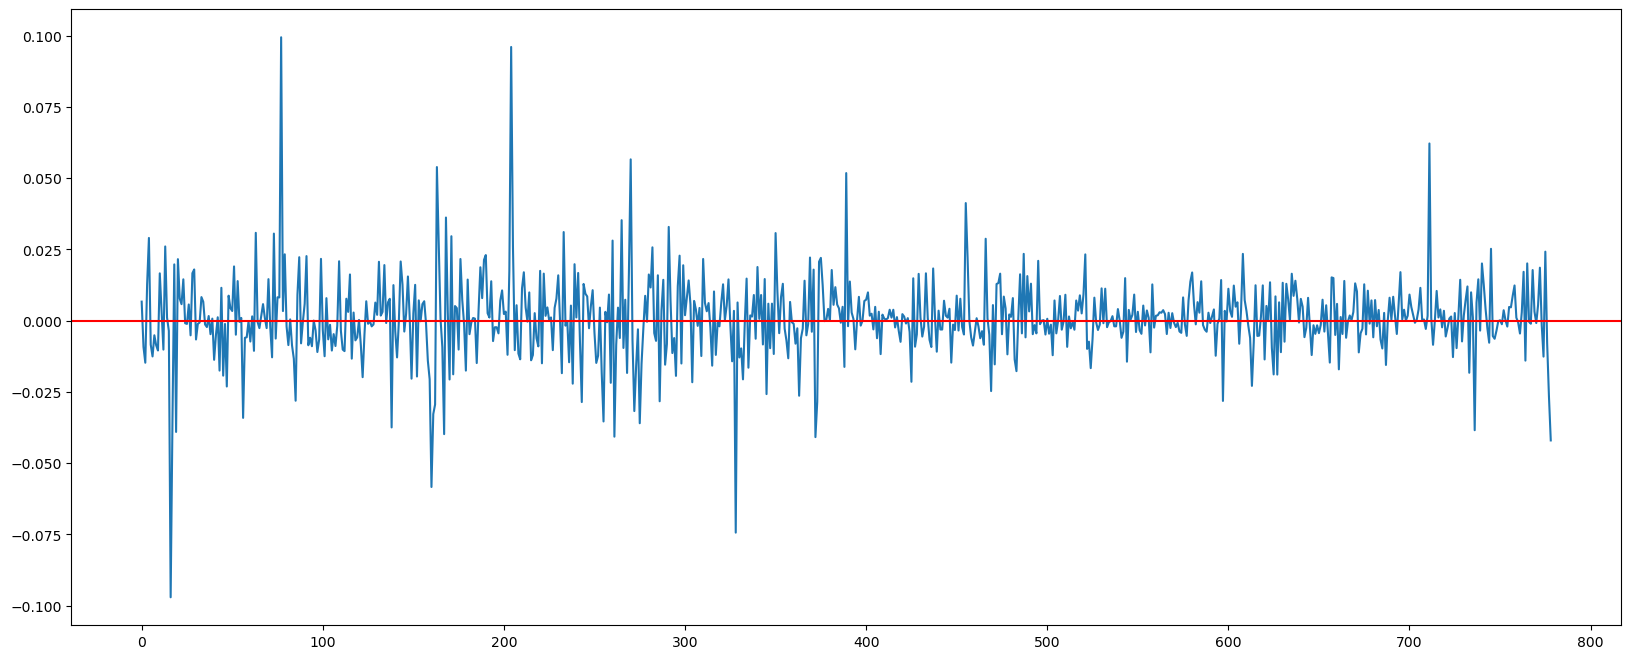

In [25]:
ms['logReturn'].plot(figsize=(20, 8))
plt.axhline(0, color='red')
plt.show()

### Step 1: Set hypothesis
$H_0 : \mu = 0$ 
$H_a : \mu \neq 0$

$H_0$ means the average stock return is 0

$H_1$ means the average stock return is not equal to 0

### Step 2: Calculate test statistic

In [26]:
sample_mean = ms['logReturn'].mean()
sample_std = ms['logReturn'].std(ddof=1)
n = ms['logReturn'].shape[0]

# if sample size n is large enough, we can use z-distribution, instead of t-distribtuion
# mu = 0 under the null hypothesis
zhat = (sample_mean - 0)/(sample_std/n**0.5)
print(zhat)

1.6141477140003675


### Step 3: Set desicion criteria

In [27]:
# confidence level
alpha = 0.05

zleft = norm.ppf(alpha/2, 0, 1)
zright = -zleft  # z-distribution is symmetric 
print(zleft, zright)

-1.9599639845400545 1.9599639845400545


### Step 4:  Make decision - shall we reject H0?

In [28]:
print('At significant level of {}, shall we reject: {}'.format(alpha, zhat>zright or zhat<zleft))

At significant level of 0.05, shall we reject: False


### An alternative method: p-value

In [29]:
p = 1 - norm.cdf(zhat, 0, 1)
print(p)

print('At significant level of {}, shall we reject: {}'.format(alpha, p < alpha))

0.053247694996968464
At significant level of 0.05, shall we reject: False


# Association between two random variables

In [30]:
housing = pd.read_csv('housing.csv', index_col=0)
housing.head()

,LSTAT,INDUS,NOX,RM,MEDV
0,4.98,2.31,0.538,6.575,24.0
1,9.14,7.07,0.469,6.421,21.6
2,4.03,7.07,0.469,7.185,34.7
3,2.94,2.18,0.458,6.998,33.4
4,5.33,2.18,0.458,7.147,36.2


In [31]:
# Use covariance to calculate the association

housing.cov()

,LSTAT,INDUS,NOX,RM,MEDV
LSTAT,50.994760,29.580270,0.488946,-3.079741,-48.447538
INDUS,29.580270,47.064442,0.607074,-1.887957,-30.520823
NOX,0.488946,0.607074,0.013428,-0.024603,-0.455412
RM,-3.079741,-1.887957,-0.024603,0.493671,4.493446
MEDV,-48.447538,-30.520823,-0.455412,4.493446,84.586724


In [32]:
# Use correlation to calculate the association is more appropriate in this case
housing.corr()

,LSTAT,INDUS,NOX,RM,MEDV
LSTAT,1.000000,0.603800,0.590879,-0.613808,-0.737663
INDUS,0.603800,1.000000,0.763651,-0.391676,-0.483725
NOX,0.590879,0.763651,1.000000,-0.302188,-0.427321
RM,-0.613808,-0.391676,-0.302188,1.000000,0.695360
MEDV,-0.737663,-0.483725,-0.427321,0.695360,1.000000


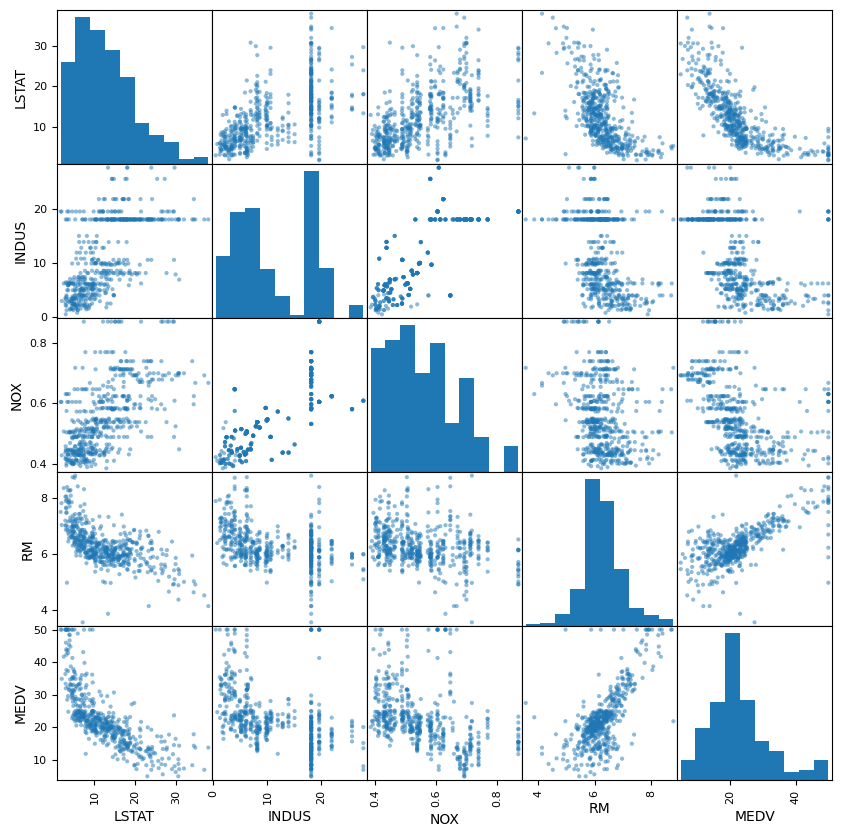

In [34]:
# scatter matrix plot
from pandas.plotting import scatter_matrix
sm = scatter_matrix(housing, figsize=(10, 10))

# Simple linear regression model

$$y_i = \beta_0 + \beta_1 * x_i + \epsilon_i $$

### We shall base on the association between LSTAT and MEDV and create a simple linear regression model. Let's use python in estimating the values of B0 and B1 (intercept and slope)

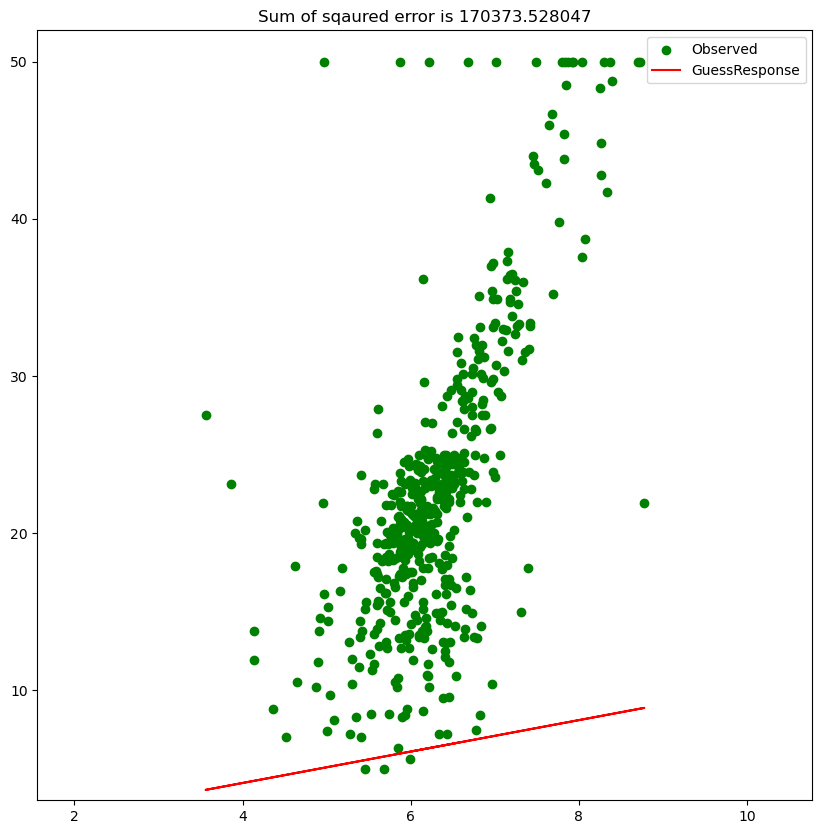

In [35]:
# lets try to guess what are the real values of intercept and slope
# we call our guess b0, b1...
# Try to assign the value of b0, b1 to get a straight line that can describe our data 
b0 = 0.1
b1 = 1
housing['GuessResponse'] = b0 + b1*housing['RM']

# Also want to know the error of of guess...
# This show how far is our guess response from the true response
housing['observederror'] = housing['MEDV'] - housing['GuessResponse']


# plot your estimated line together with the points
plt.figure(figsize=(10, 10))
plt.title('Sum of sqaured error is {}'.format((((housing['observederror'])**2)).sum()))
plt.scatter(housing['RM'], housing['MEDV'], color='g', label='Observed')
plt.plot(housing['RM'], housing['GuessResponse'], color='red', label='GuessResponse')
plt.legend()
plt.xlim(housing['RM'].min()-2, housing['RM'].max()+2)
plt.ylim(housing['MEDV'].min()-2, housing['MEDV'].max()+2)
plt.show()

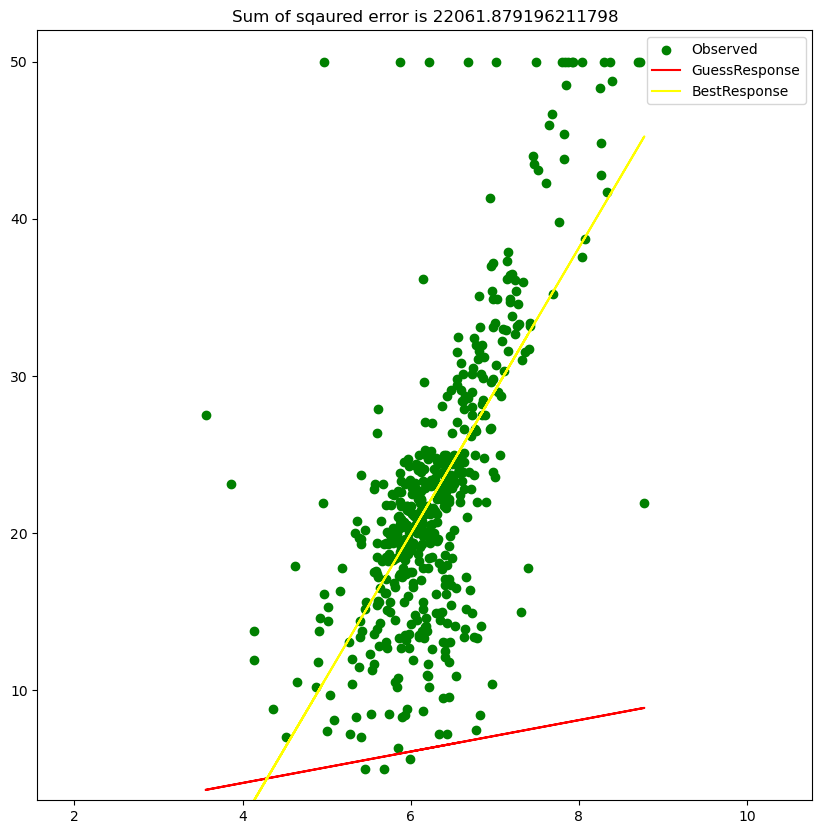

In [38]:
import statsmodels.formula.api as smf
formula ='MEDV~RM'
model = smf.ols(formula=formula, data=housing).fit()

# Here are estimated intercept and slope by least square estimation
# Attribute 'params' returns a list of estimated parameters form model
b0_ols = model.params[0]
b1_ols = model.params[1]

housing['BestResponse'] = b0_ols + b1_ols*housing['RM']

# Also want to know the error of of guess...
housing['error'] = housing['MEDV'] - housing['BestResponse']


# plot your estimated line together with the points
plt.figure(figsize=(10, 10))
# See if the error drops after you use least square method
plt.title('Sum of sqaured error is {}'.format((((housing['error'])**2)).sum()))
plt.scatter(housing['RM'], housing['MEDV'], color='g', label='Observed')
plt.plot(housing['RM'], housing['GuessResponse'], color='red', label='GuessResponse')
plt.plot(housing['RM'], housing['BestResponse'], color='yellow', label='BestResponse')
plt.legend()
plt.xlim(housing['RM'].min()-2, housing['RM'].max()+2)
plt.ylim(housing['MEDV'].min()-2, housing['MEDV'].max()+2)
plt.show()

In [39]:
#Refer to the P-value of RM, Confidence Interval and R-square to evaluate the performance.
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   MEDV   R-squared:                       0.484
Model:                            OLS   Adj. R-squared:                  0.483
Method:                 Least Squares   F-statistic:                     471.8
Date:                Wed, 16 Nov 2022   Prob (F-statistic):           2.49e-74
Time:                        17:18:41   Log-Likelihood:                -1673.1
No. Observations:                 506   AIC:                             3350.
Df Residuals:                     504   BIC:                             3359.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -34.6706      2.650    -13.084      0.000     -39.877     -29.465
RM             9.1021      0.419     21.722      0.000       8.279       9.925
==============================================================================
Omnibus:                      102.585   Durbin-Watson:                   0.684
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              612.449
Skew:                           0.726   Prob(JB):                    1.02e-133
Kurtosis:                       8.190   Cond. No.                         58.4
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

# Multiple linear regression model

In [42]:
# import all stock market data into DataFrame
aord = pd.read_csv('ALLOrdinary.csv')
nikkei = pd.read_csv('Nikkei225.csv')
hsi = pd.read_csv('HSI.csv')
daxi = pd.read_csv('DAXI.csv')
cac40 = pd.read_csv('CAC40.csv')
sp500 = pd.read_csv('SP500.csv')
dji = pd.read_csv('DJI.csv')
nasdaq = pd.read_csv('nasdaq_composite.csv')
spy = pd.read_csv('SPY.csv')

## Step 1: Data Munging

In [43]:
# Due to the timezone issues, we extract and calculate appropriate stock market data for analysis
# Indicepanel is the DataFrame of our trading model
indicepanel=pd.DataFrame(index=spy.index)

indicepanel['spy']=spy['Open'].shift(-1)-spy['Open']
indicepanel['spy_lag1']=indicepanel['spy'].shift(1)
indicepanel['sp500']=sp500["Open"]-sp500['Open'].shift(1)
indicepanel['nasdaq']=nasdaq['Open']-nasdaq['Open'].shift(1)
indicepanel['dji']=dji['Open']-dji['Open'].shift(1)

indicepanel['cac40']=cac40['Open']-cac40['Open'].shift(1)
indicepanel['daxi']=daxi['Open']-daxi['Open'].shift(1)

indicepanel['aord']=aord['Close']-aord['Open']
indicepanel['hsi']=hsi['Close']-hsi['Open']
indicepanel['nikkei']=nikkei['Close']-nikkei['Open']
indicepanel['Price']=spy['Open']

In [44]:
indicepanel.head()

,spy,spy_lag1,sp500,nasdaq,dji,cac40,daxi,aord,hsi,nikkei,Price
0,-1.619995,NaN,NaN,NaN,NaN,NaN,NaN,15.500000,-71.679688,-464.320313,146.529999
1,-1.570008,-1.619995,-20.419922,-41.949951,-217.70019,-71.779785,-104.450195,-50.100097,-162.750000,-48.830078,144.910004
2,-1.529998,-1.570008,-3.540039,-40.879883,2.43945,5.489746,-27.990235,-2.300293,515.349609,99.370117,143.339996
3,0.270004,-1.529998,-29.940064,-56.930176,-245.40918,-111.689941,-102.709961,-117.399903,216.951171,234.450195,141.809998
4,-2.990006,0.270004,1.640015,-7.179931,19.75000,44.509766,33.680176,-27.500000,-354.060547,-158.209961,142.080002


In [45]:
# Lets check whether do we have NaN values in indicepanel
indicepanel.isnull().sum()

spy          1
spy_lag1     1
sp500        1
nasdaq       1
dji          1
cac40        3
daxi        11
aord         2
hsi         57
nikkei      57
Price        0
dtype: int64

In [46]:
# We can use method 'fillna()' from dataframe to forward filling the Nan values
# Then we can drop the reminding Nan values
indicepanel = indicepanel.fillna(method='ffill')
indicepanel = indicepanel.dropna()

In [47]:
# Lets check whether do we have Nan values in indicepanel now
indicepanel.isnull().sum()

spy         0
spy_lag1    0
sp500       0
nasdaq      0
dji         0
cac40       0
daxi        0
aord        0
hsi         0
nikkei      0
Price       0
dtype: int64

In [48]:
# save this indicepanel for part 4.5
path_save = 'indicepanel.csv'
indicepanel.to_csv(path_save)

In [49]:
print(indicepanel.shape)

(2678, 11)


## Step 2: Data Spliting


In [50]:
#split the data into (1)train set and (2)test set

Train = indicepanel.iloc[-2000:-1000, :]
Test = indicepanel.iloc[-1000:, :]
print(Train.shape, Test.shape)

(1000, 11) (1000, 11)


## Step 3: Explore the train data set

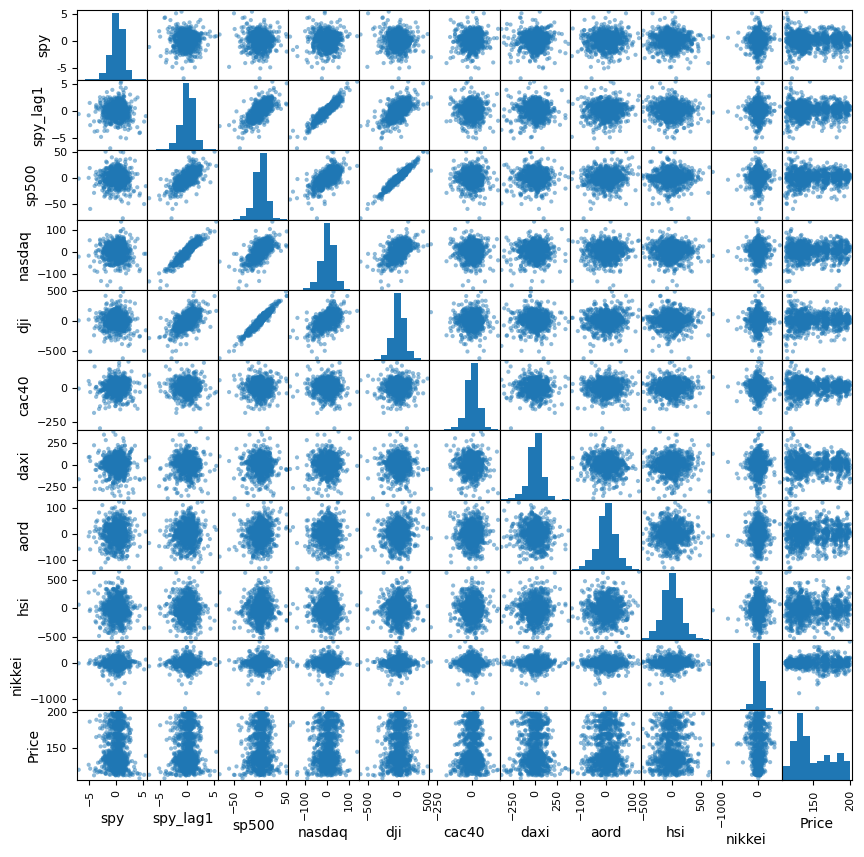

In [51]:
from pandas.plotting import scatter_matrix
sm = scatter_matrix(Train, figsize=(10, 10))

## Step 4: Check the correlation of each index between spy

In [52]:
# Find the indice with largest correlation
corr_array = Train.iloc[:, :-1].corr()['spy']
print(corr_array)

spy         1.000000
spy_lag1   -0.011623
sp500      -0.018632
nasdaq      0.012333
dji        -0.037097
cac40       0.076886
daxi        0.019410
aord        0.048200
hsi        -0.038361
nikkei      0.035379
Name: spy, dtype: float64


In [53]:
formula = 'spy~spy_lag1+sp500+nasdaq+dji+cac40+aord+daxi+nikkei+hsi'
lm = smf.ols(formula=formula, data=Train).fit()
print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:                    spy   R-squared:                       0.019
Model:                            OLS   Adj. R-squared:                  0.010
Method:                 Least Squares   F-statistic:                     2.133
Date:                Wed, 16 Nov 2022   Prob (F-statistic):             0.0245
Time:                        17:38:40   Log-Likelihood:                -1643.1
No. Observations:                1000   AIC:                             3306.
Df Residuals:                     990   BIC:                             3355.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0798      0.040      1.993      0.0

## Step 5: Make prediction

In [54]:
Train['PredictedY'] = lm.predict(Train)
Test['PredictedY'] = lm.predict(Test)

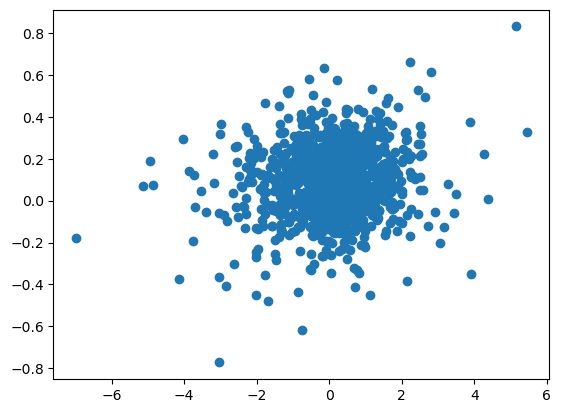

In [55]:
plt.scatter(Train['spy'], Train['PredictedY'])

## Step 6: Model evaluation - Statistical standard

In [56]:
# RMSE - Root Mean Squared Error, Adjusted R^2
def adjustedMetric(data, model, model_k, yname):
    data['yhat'] = model.predict(data)
    SST = ((data[yname] - data[yname].mean())**2).sum()
    SSR = ((data['yhat'] - data[yname].mean())**2).sum()
    SSE = ((data[yname] - data['yhat'])**2).sum()
    r2 = SSR/SST
    adjustR2 = 1 - (1-r2)*(data.shape[0] - 1)/(data.shape[0] -model_k -1)
    RMSE = (SSE/(data.shape[0] -model_k -1))**0.5
    return adjustR2, RMSE

In [57]:
def assessTable(test, train, model, model_k, yname):
    r2test, RMSEtest = adjustedMetric(test, model, model_k, yname)
    r2train, RMSEtrain = adjustedMetric(train, model, model_k, yname)
    assessment = pd.DataFrame(index=['R2', 'RMSE'], columns=['Train', 'Test'])
    assessment['Train'] = [r2train, RMSEtrain]
    assessment['Test'] = [r2test, RMSEtest]
    return assessment

In [58]:
# Get the assement table fo our model
assessTable(Test, Train, lm, 9, 'spy')

,Train,Test
R2,0.010102,0.013609
RMSE,1.257534,1.759693
